# GANs

GANs, generatlized adversarial networks, are ways to use deep learning to generate data that has very high fidelity to a set of actual data. If you haven't seen some of the generated images from GANs, check them out! We'll try a very simple version where we're going to generate cryptopunks. I drew heavily from [here](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) for all of the code.

## GAN implementations

GANs work by two parts. I'll describe this by imagining breaking our autoencoder into two parts. Recall, our autoencoder diagram as seen below.

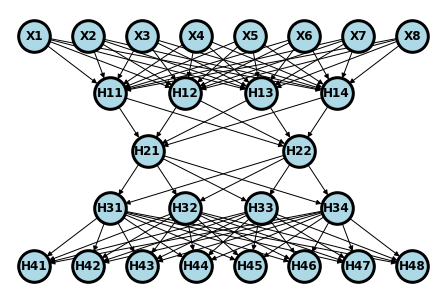

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl

#plt.figure(figsize=[2, 2])
G = nx.DiGraph()
G.add_node("X1",  pos = (0, 5) )
G.add_node("X2",  pos = (1, 5) )
G.add_node("X3",  pos = (2, 5) )
G.add_node("X4",  pos = (3, 5) )
G.add_node("X5",  pos = (4, 5) )
G.add_node("X6",  pos = (5, 5) )
G.add_node("X7",  pos = (6, 5) )
G.add_node("X8",  pos = (7, 5) )

G.add_node("H11",  pos = (1.4, 4) )
G.add_node("H12",  pos = (2.8, 4) )
G.add_node("H13",  pos = (4.2, 4) )
G.add_node("H14",  pos = (5.6, 4) )

G.add_node("H21",  pos = (2.1, 3) )
G.add_node("H22",  pos = (4.9, 3) )

G.add_node("H31",  pos = (1.4, 2) )
G.add_node("H32",  pos = (2.8, 2) )
G.add_node("H33",  pos = (4.2, 2) )
G.add_node("H34",  pos = (5.6, 2) )


G.add_node("H41",  pos = (0, 1) )
G.add_node("H42",  pos = (1, 1) )
G.add_node("H43",  pos = (2, 1) )
G.add_node("H44",  pos = (3, 1) )
G.add_node("H45",  pos = (4, 1) )
G.add_node("H46",  pos = (5, 1) )
G.add_node("H47",  pos = (6, 1) )
G.add_node("H48",  pos = (7, 1) )

G.add_edges_from([ ("X1", "H11"),  ("X1", "H12"),  ("X1", "H13"),  ("X1", "H14")])
G.add_edges_from([ ("X2", "H11"),  ("X2", "H12"),  ("X2", "H13"),  ("X2", "H14")])
G.add_edges_from([ ("X3", "H11"),  ("X3", "H12"),  ("X3", "H13"),  ("X3", "H14")])
G.add_edges_from([ ("X4", "H11"),  ("X4", "H12"),  ("X4", "H13"),  ("X4", "H14")])
G.add_edges_from([ ("X5", "H11"),  ("X5", "H12"),  ("X5", "H13"),  ("X5", "H14")])
G.add_edges_from([ ("X6", "H11"),  ("X6", "H12"),  ("X6", "H13"),  ("X6", "H14")])
G.add_edges_from([ ("X7", "H11"),  ("X7", "H12"),  ("X7", "H13"),  ("X7", "H14")])
G.add_edges_from([ ("X8", "H11"),  ("X8", "H12"),  ("X8", "H13"),  ("X8", "H14")])

G.add_edges_from([ ("H11", "H21"),  ("H11", "H22")])
G.add_edges_from([ ("H12", "H21"),  ("H12", "H22")])
G.add_edges_from([ ("H13", "H21"),  ("H13", "H22")])
G.add_edges_from([ ("H14", "H21"),  ("H14", "H22")])


G.add_edges_from([ ("H21", "H31"),  ("H21", "H32"),  ("H21", "H33"),  ("H21", "H34")])
G.add_edges_from([ ("H22", "H31"),  ("H22", "H32"),  ("H22", "H33"),  ("H22", "H34")])

G.add_edges_from([ ("H31", "H41"),  ("H31", "H42"),  ("H31", "H43"),  ("H31", "H44")])
G.add_edges_from([ ("H31", "H45"),  ("H31", "H46"),  ("H31", "H47"),  ("H31", "H48")])
G.add_edges_from([ ("H32", "H41"),  ("H32", "H42"),  ("H32", "H43"),  ("H32", "H44")])
G.add_edges_from([ ("H32", "H45"),  ("H32", "H46"),  ("H32", "H47"),  ("H32", "H48")])
G.add_edges_from([ ("H33", "H41"),  ("H33", "H42"),  ("H33", "H43"),  ("H33", "H44")])
G.add_edges_from([ ("H33", "H45"),  ("H33", "H46"),  ("H33", "H47"),  ("H33", "H48")])
G.add_edges_from([ ("H34", "H41"),  ("H34", "H42"),  ("H34", "H43"),  ("H34", "H44")])
G.add_edges_from([ ("H34", "H45"),  ("H34", "H46"),  ("H34", "H47"),  ("H34", "H48")])


#G.add_edges_from([("H11", "H21"), ("H11", "H22"), ("H12", "H21"), ("H12", "H22")])
#G.add_edges_from([("H21", "Y"), ("H22", "Y")])
nx.draw(G, 
        nx.get_node_attributes(G, 'pos'), 
        with_labels=True, 
        font_weight='bold', 
        node_size = 1000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.5, 7.5])
ax.set_ylim([.5, 5.5])
plt.show()

Again, consider breaking this digram into two parts. One that takes the embedding and spits out images (a generator) and one that takes in images and spits out guesses as to whether or not they are real (a discriminator). See below where the generator is on the left and the discriminator is on the right.

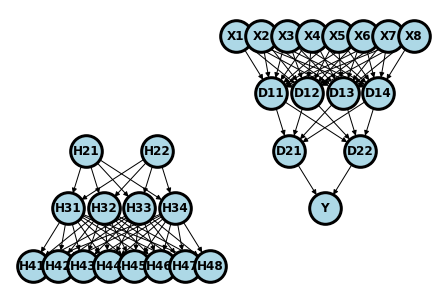

In [9]:
#plt.figure(figsize=[2, 2])
G = nx.DiGraph()


#plt.figure(figsize=[2, 2])
G = nx.DiGraph()
G.add_node("X1",  pos = ( 8, 5) )
G.add_node("X2",  pos = ( 9, 5) )
G.add_node("X3",  pos = (10, 5) )
G.add_node("X4",  pos = (11, 5) )
G.add_node("X5",  pos = (12, 5) )
G.add_node("X6",  pos = (13, 5) )
G.add_node("X7",  pos = (14, 5) )
G.add_node("X8",  pos = (15, 5) )

G.add_node("D11",  pos = ( 9.4, 4) )
G.add_node("D12",  pos = (10.8, 4) )
G.add_node("D13",  pos = (12.2, 4) )
G.add_node("D14",  pos = (13.6, 4) )

G.add_node("D21",  pos = (10.1, 3) )
G.add_node("D22",  pos = (12.9, 3) )

G.add_node( "Y",   pos = (11.5, 2) )

G.add_node("H21",  pos = (2.1, 3) )
G.add_node("H22",  pos = (4.9, 3) )

G.add_node("H31",  pos = (1.4, 2) )
G.add_node("H32",  pos = (2.8, 2) )
G.add_node("H33",  pos = (4.2, 2) )
G.add_node("H34",  pos = (5.6, 2) )


G.add_node("H41",  pos = (0, 1) )
G.add_node("H42",  pos = (1, 1) )
G.add_node("H43",  pos = (2, 1) )
G.add_node("H44",  pos = (3, 1) )
G.add_node("H45",  pos = (4, 1) )
G.add_node("H46",  pos = (5, 1) )
G.add_node("H47",  pos = (6, 1) )
G.add_node("H48",  pos = (7, 1) )

G.add_edges_from([ ("X1", "D11"),  ("X1", "D12"),  ("X1", "D13"),  ("X1", "D14")])
G.add_edges_from([ ("X2", "D11"),  ("X2", "D12"),  ("X2", "D13"),  ("X2", "D14")])
G.add_edges_from([ ("X3", "D11"),  ("X3", "D12"),  ("X3", "D13"),  ("X3", "D14")])
G.add_edges_from([ ("X4", "D11"),  ("X4", "D12"),  ("X4", "D13"),  ("X4", "D14")])
G.add_edges_from([ ("X5", "D11"),  ("X5", "D12"),  ("X5", "D13"),  ("X5", "D14")])
G.add_edges_from([ ("X6", "D11"),  ("X6", "D12"),  ("X6", "D13"),  ("X6", "D14")])
G.add_edges_from([ ("X7", "D11"),  ("X7", "D12"),  ("X7", "D13"),  ("X7", "D14")])
G.add_edges_from([ ("X8", "D11"),  ("X8", "D12"),  ("X8", "D13"),  ("X8", "D14")])

G.add_edges_from([ ("D11", "D21"),  ("D11", "D22")])
G.add_edges_from([ ("D12", "D21"),  ("D12", "D22")])
G.add_edges_from([ ("D13", "D21"),  ("D13", "D22")])
G.add_edges_from([ ("D14", "D21"),  ("D14", "D22")])


G.add_edges_from([ ("D21", "Y"),  ("D22", "Y")])


G.add_edges_from([ ("H21", "H31"),  ("H21", "H32"),  ("H21", "H33"),  ("H21", "H34")])
G.add_edges_from([ ("H22", "H31"),  ("H22", "H32"),  ("H22", "H33"),  ("H22", "H34")])

G.add_edges_from([ ("H31", "H41"),  ("H31", "H42"),  ("H31", "H43"),  ("H31", "H44")])
G.add_edges_from([ ("H31", "H45"),  ("H31", "H46"),  ("H31", "H47"),  ("H31", "H48")])
G.add_edges_from([ ("H32", "H41"),  ("H32", "H42"),  ("H32", "H43"),  ("H32", "H44")])
G.add_edges_from([ ("H32", "H45"),  ("H32", "H46"),  ("H32", "H47"),  ("H32", "H48")])
G.add_edges_from([ ("H33", "H41"),  ("H33", "H42"),  ("H33", "H43"),  ("H33", "H44")])
G.add_edges_from([ ("H33", "H45"),  ("H33", "H46"),  ("H33", "H47"),  ("H33", "H48")])
G.add_edges_from([ ("H34", "H41"),  ("H34", "H42"),  ("H34", "H43"),  ("H34", "H44")])
G.add_edges_from([ ("H34", "H45"),  ("H34", "H46"),  ("H34", "H47"),  ("H34", "H48")])


#G.add_edges_from([("H11", "H21"), ("H11", "H22"), ("H12", "H21"), ("H12", "H22")])
#G.add_edges_from([("H21", "Y"), ("H22", "Y")])
nx.draw(G, 
        nx.get_node_attributes(G, 'pos'), 
        with_labels=True, 
        font_weight='bold', 
        node_size = 1000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-1, 16])
ax.set_ylim([.5, 5.5])
plt.show()

GANs do something like the following. They generate data (H21 and H22 above) using a random number generator. These are passed through the generator to obtain simulated records (H41-H48). These fake records are concatenated with real records to be passed through the discriminator, which tries to guess whether the records are real or fake. The two networks are trained adversarially. That is, the generator has higher loss when it fails to fool the discriminator and the discriminator has higher loss when it fails to discriminate between real and fake records.

This sort of approach can be used for data of any type. But, it's fun especially to do it using images. Some of the images generated from GANs are wild in how realistic looking they are. Let's try to create a GAN to generate our cryptopunks.

In [10]:
#import argparse
#import os
#import random
#import torch.utils.data
#import torchvision.transforms as transforms
#import torchvision.utils as vutils
#from IPython.display import HTML
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import urllib.request
import PIL

## Read in and organize the data
imgURL = "https://raw.githubusercontent.com/larvalabs/cryptopunks/master/punks.png"
urllib.request.urlretrieve(imgURL, "cryptoPunksAll.jpg")
img = PIL.Image.open("cryptoPunksAll.jpg").convert("RGB")
imgArray = np.asarray(img)
finalArray = np.empty((10000, 3, 24, 24))
for i in range(100):
  for j in range(100):
    a, b = 24 * i, 24 * (i + 1)  
    c, d = 24 * j, 24 * (j + 1) 
    idx = j + i * (100)
    finalArray[idx,0,:,:] = imgArray[a:b,c:d,0]
    finalArray[idx,1,:,:] = imgArray[a:b,c:d,1]
    finalArray[idx,2,:,:] = imgArray[a:b,c:d,2]

n = finalArray.shape[0]
x_real = finalArray / 255
x_real = torch.tensor(x_real.astype(np.float32))
x_real.shape

torch.Size([10000, 3, 24, 24])

For the generator, we'll use the same construction as the decoding layer from our autoencoder chapter. For the discriminator, let's use the same network we used in our convolutional NN chapter.

In [11]:
## Define our constants
kernel_size = 5
generator_input_dim = [24, 1, 1]
lr = 1e-5

In [12]:
class create_generator(nn.Module):
    def __init__(self):
        super().__init__()        
        self.iconv0 = nn.ConvTranspose2d(24, 12, kernel_size+1) 
        self.iconv1 = nn.ConvTranspose2d(12, 6, kernel_size+1, stride = 2)
        self.iconv2 = nn.ConvTranspose2d(6, 3, kernel_size+1, stride = 2)
        self.pool   = nn.MaxPool2d(2, 2)
    def forward(self, x):
        x = F.relu(self.iconv0(x))
        x = self.pool(x)
        x = F.relu(self.iconv1(x))
        x = torch.sigmoid(self.iconv2(x))
        return x;
    
## Use the discriminator from the convnet chapter
class create_discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 3 * 3, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
    
        
generator = create_generator()
discriminator = create_discriminator()


Let's try out our generator. First, we're going to generate n embeddings. Then we'll feed them through the generator to obtain n images. Notice that they don't look so good. This is because we haven't trained out generator yet!

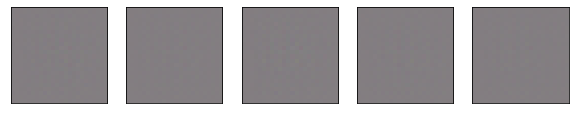

In [13]:
test_embedding = torch.randn([5]+generator_input_dim)
#print(test_embedding.size())
x_fake = generator(test_embedding)
#print(x_fake.shape)

## Plot out the first 5 images, note this isn't very interesting, since
## all of the weights haven't been trained
plt.figure(figsize=(10,5))
for i in range(5): 
  plt.subplot(1, 5,i+1)
  plt.xticks([])
  plt.yticks([])
  img = np.transpose(x_fake.detach().numpy()[i,:,:,:], (1, 2, 0))
  plt.imshow(img)



In [14]:
## Define our real and fake labels
real_label = 1
fake_label = 0

## y is n real images then n fake images
y = torch.concat( (torch.ones(n), torch.zeros(n) ) ) 

## Set up optimizers
optimizerD = optim.Adam(discriminator.parameters(), lr=lr)
optimizerG = optim.Adam(generator.parameters(), lr=lr)

## Set up the loss function
loss_function = nn.BCELoss()

In [15]:
n_epochs = 10

for epoch in range(n_epochs):
    ## Generate data
    embedding = torch.randn([n]+generator_input_dim)
    ## Generate new fake images
    x_fake = generator(embedding)

    ###########################################################################
    ## TRAIN DISCRIMINATOR                                                   ##
    ###########################################################################
    discriminator.zero_grad()

    ## run the generated and fake images through the discriminator
    yhat_fake = discriminator(x_fake)
    yhat_real = discriminator(x_real)
    yhat = torch.concat( (yhat_fake, yhat_real) ).reshape(-1)

    # Calculate loss on all-real batch
    discriminator_error = loss_function(yhat, y)

    # Calculate gradients for D in backward pass
    discriminator_error.backward()

    # Update the discriminator
    optimizerD.step()

    ###########################################################################
    ## Generator                                                             ##
    ###########################################################################
    generator.zero_grad()
    ## The discriminator has been udpated, so push the data through the 
    ## new discriminator
    yhat_fake = discriminator(x_fake)
    ## Note the outcome for the generator is all ones even
    ## though we're classifying real as 1 and fake as 0
    ## In other words, we want the loss for the generator to be
    ## based on how real-like the generated data is
    generator_error = loss_function(yhat_fake, torch.ones((n, 1)))
    ## Calculate the backwards error
    generator_error.backward
    # Update the discriminator
    optimizerG.step()


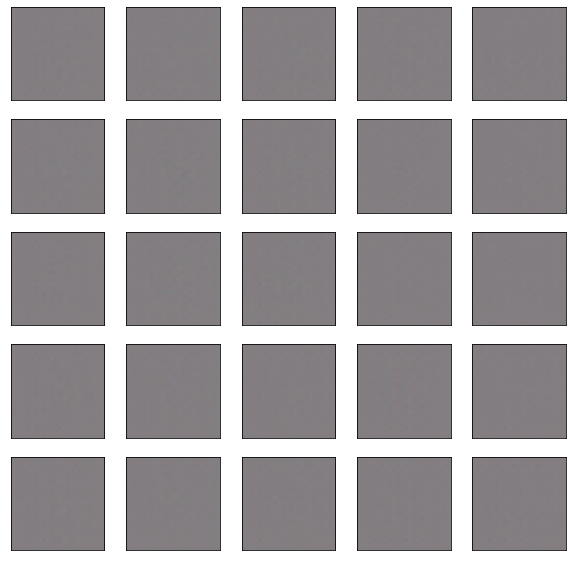

In [17]:
plt.figure(figsize=(10,10))
for i in range(25): 
  plt.subplot(5, 5,i+1)
  plt.xticks([])
  plt.yticks([])
  img = np.transpose(x_fake.detach().numpy()[i,:,:,:], (1, 2, 0))
  plt.imshow(img)
